In [1]:
import pandas as pd

data = pd.read_excel('hackaton_data_5post.xlsx')
data.head()

,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly
0,"г.Калуга, Литейная ул., 25/15",КАЛУГА,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,NaN,остановка,423321
1,"г.Калуга, Гагарина ул., 1",КАЛУГА,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,NaN,остановка,423321
2,"г.Калуга, Кибальчича ул., 25",КАЛУГА,Калужская область,NaN,3.1,NaN,12.0,1.0,5553.0,10100,3436,324698,1,0,NaN,NaN,423321
3,"г.Калуга, Пестеля ул., 60/49",КАЛУГА,Калужская область,3.0,2.2,0.0,12.0,1.0,7162.0,10099,3257,324698,0,0,NaN,NaN,423321
4,"г.Калуга, Ленина ул., 81",КАЛУГА,Калужская область,1.0,2.0,0.0,9.0,1.0,6269.0,10096,3195,324698,1,0,NaN,остановка,423321


In [4]:
def replace_binary_value(b):
    if b and pd.notnull(b):
        return 1
    else:
        return -1

data.iloc[:, 12:16] = data.iloc[:, 12:16].agg(lambda row: row.agg(replace_binary_value, axis=0), axis=1)

data_kal_obl = data[data['REGION'] == 'Калужская область']
data_tul_obl = data[data['REGION'] == 'Тульская область']

/Users/kostya/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kostya/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


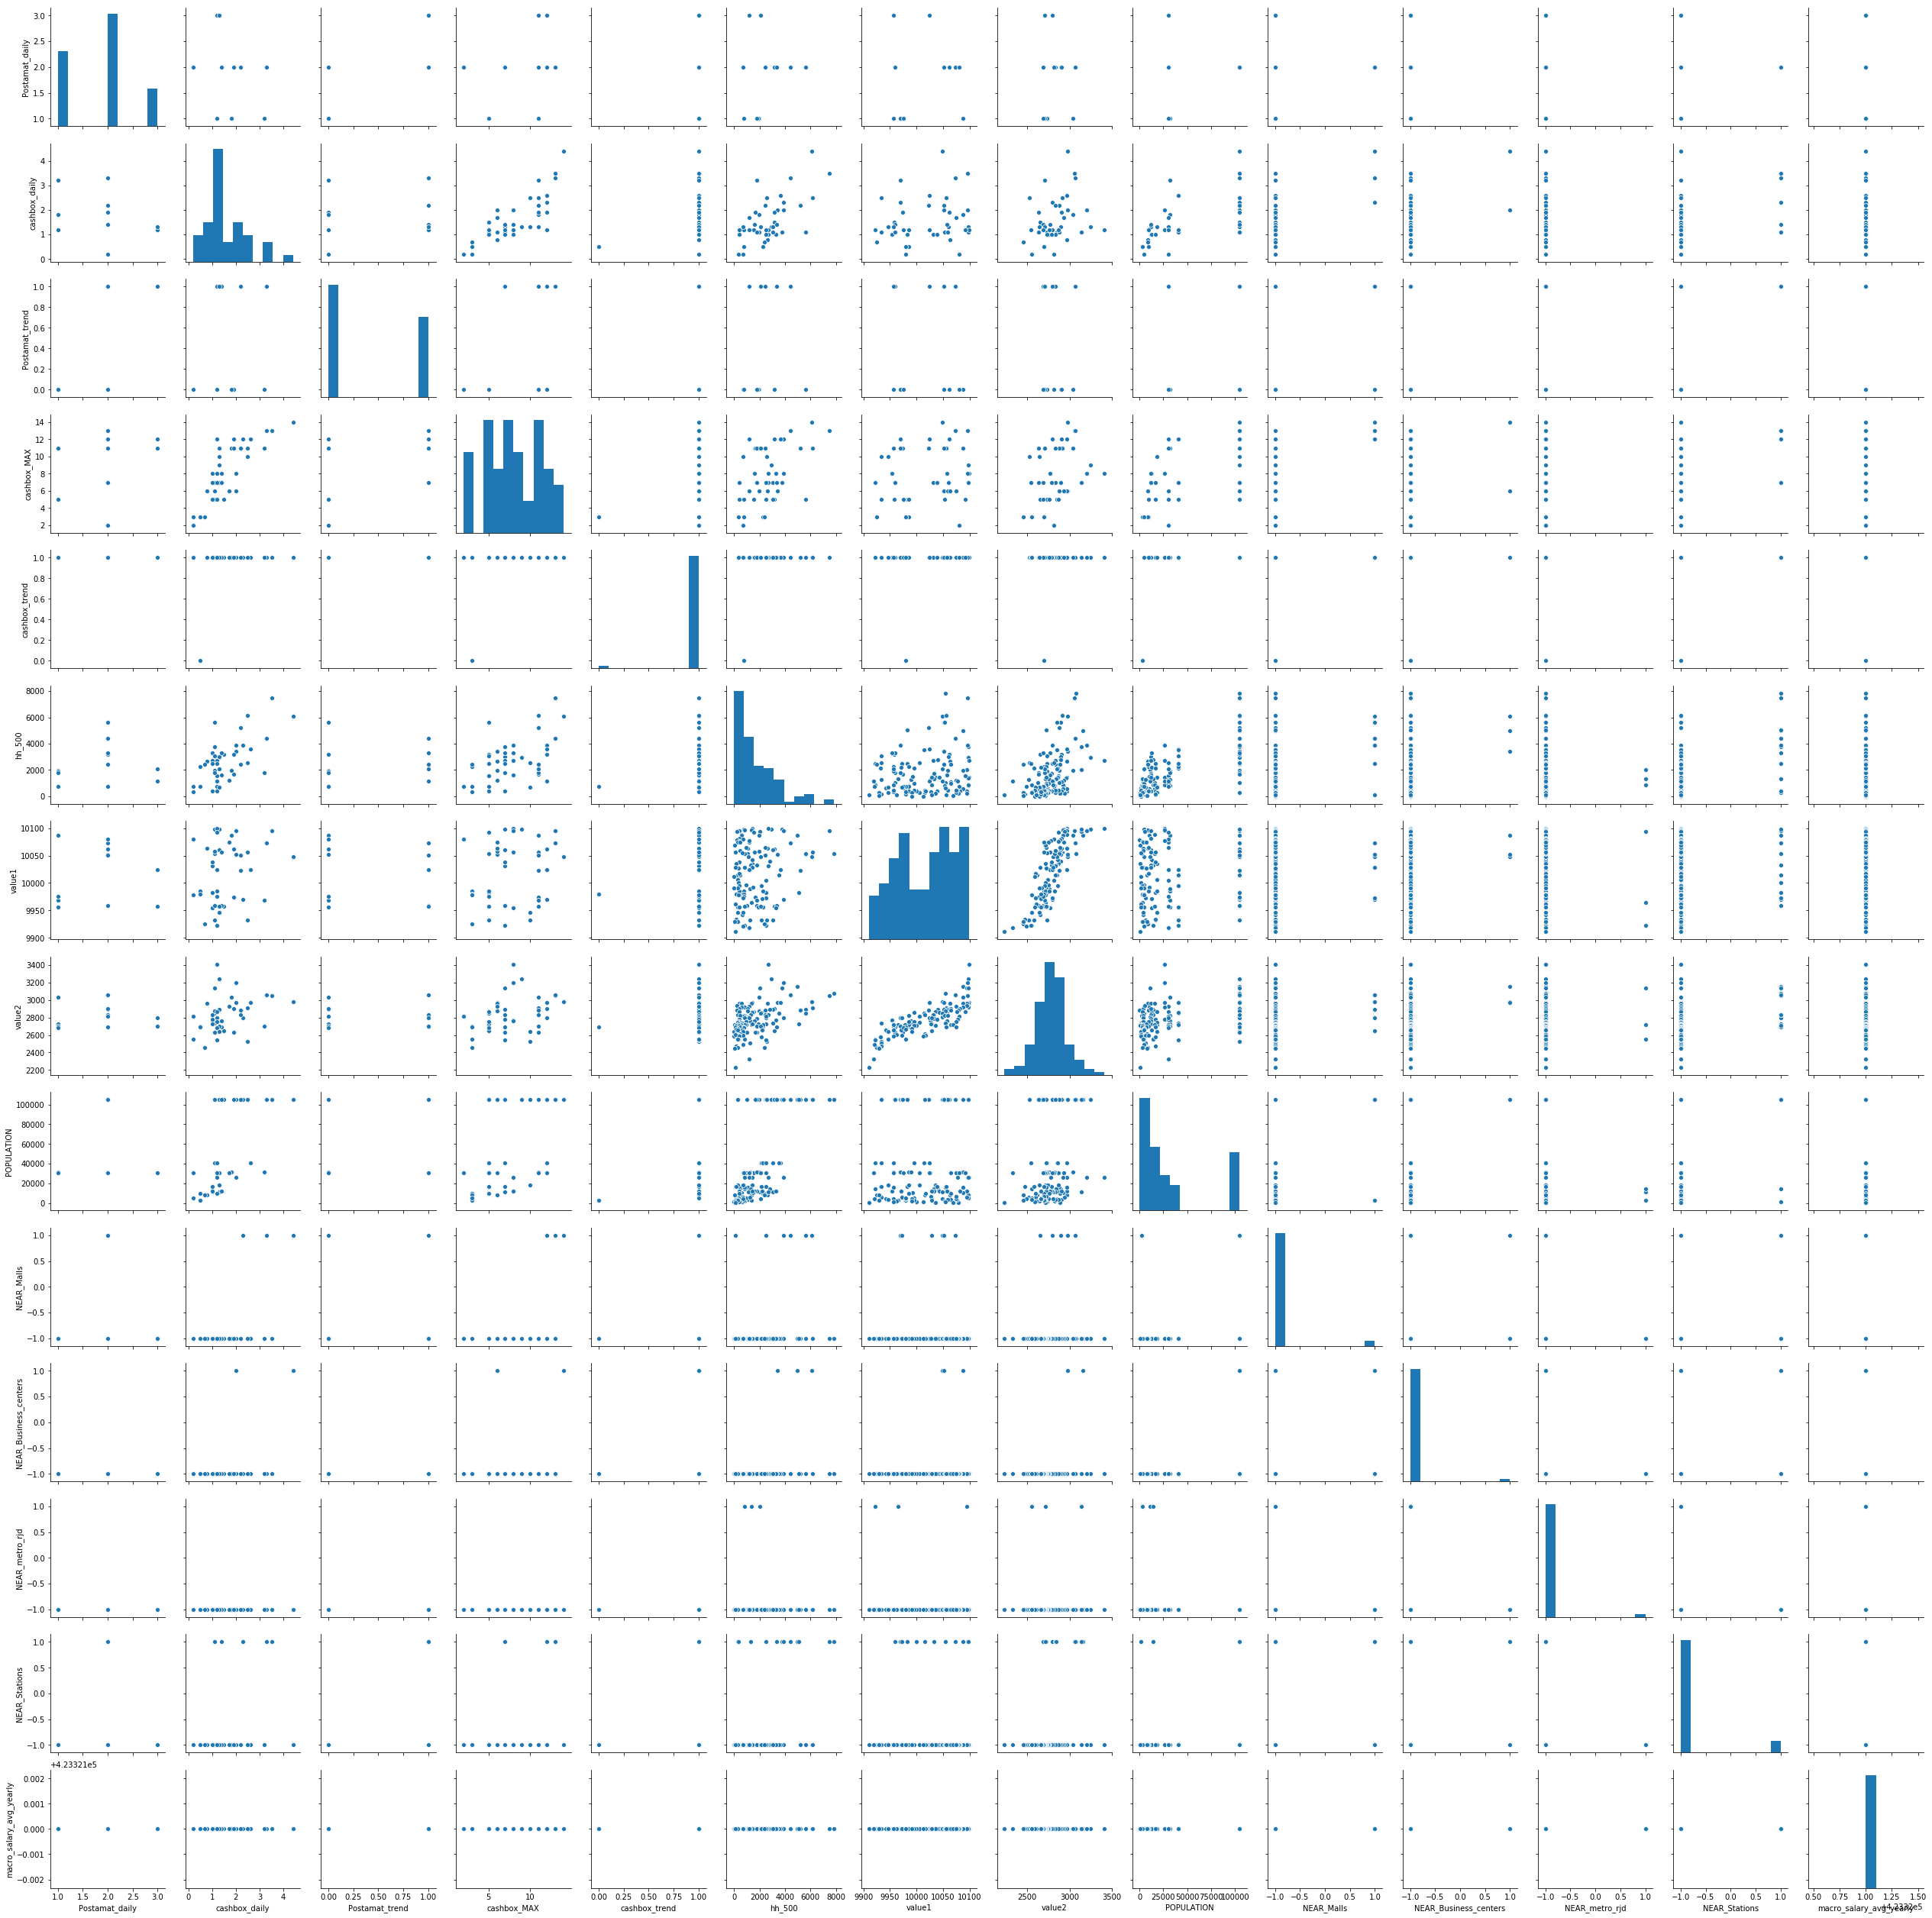

In [15]:
import seaborn as sns

sns.pairplot(data_kal_obl.iloc[:, 3:17])

In [14]:
data_kaluga = data_kal_obl[data_kal_obl['CITY'] == 'КАЛУГА']
data_tula = data_tul_obl[data_tul_obl['CITY'] == 'ТУЛА']
data_kal_obl = data_kal_obl[data_kal_obl['CITY'] != 'КАЛУГА']
data_tul_obl = data_tul_obl[data_tul_obl['CITY'] != 'ТУЛА']

In [87]:
X = data_kaluga[data_kaluga['cashbox_daily'].notnull()].iloc[:, 6:18]

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 239
Data columns (total 9 columns):
cashbox_MAX              57 non-null float64
cashbox_trend            55 non-null float64
hh_500                   57 non-null float64
value1                   57 non-null int64
value2                   57 non-null int64
NEAR_Malls               57 non-null int64
NEAR_Business_centers    57 non-null int64
NEAR_metro_rjd           57 non-null int64
NEAR_Stations            57 non-null int64
dtypes: float64(3), int64(6)
memory usage: 4.5 KB


In [95]:
import numpy as np

X.fillna(0, inplace=True)
X = (X - X.mean()) / X.std()

In [102]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

lasso = Lasso(0.05)
ridge = Ridge()
lin_reg = LinearRegression()

In [103]:
y = data_kaluga[data_kaluga['cashbox_daily'].notnull()].cashbox_daily
y = (y - y.mean()) / y.std()

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lasso.fit(X_train, y_train)
print(mse(y_test, lasso.predict(X_test)), mae(y_test, lasso.predict(X_test)))

0.12881670606624254 0.3009872883789938


In [106]:
lasso.fit(X, y)
lasso.coef_

array([ 0.7950587 ,  0.        ,  0.        ,  0.04516096,  0.05593081,
       -0.        ,  0.        ,  0.01609916, -0.06898949])

In [111]:
lasso.fit(X.drop(labels='value1', axis=1), y)
lasso.coef_

array([ 0.7949395 ,  0.        ,  0.        ,  0.09664327, -0.        ,
        0.        ,  0.01323896, -0.07149039])

In [113]:
lasso.fit(X.drop(labels='value2', axis=1), y)
lasso.coef_

array([ 0.79889328,  0.        ,  0.00198145,  0.09487306, -0.        ,
        0.        ,  0.01836106, -0.0664145 ])

In [116]:
X.drop(labels=['cashbox_trend', 'value2', 'NEAR_Malls', 'NEAR_Business_centers'], axis=1, inplace=True)

In [117]:
X.head()

,cashbox_MAX,hh_500,value1,NEAR_metro_rjd,NEAR_Stations
0,1.494381,1.675132,1.290828,-0.132453,1.044805
2,1.212329,0.744297,1.307995,-0.132453,-0.940325
3,1.212329,1.443183,1.290828,-0.132453,-0.940325
4,0.366173,1.055299,1.239327,-0.132453,1.044805
6,-0.479983,1.678173,1.101992,-0.132453,1.044805


In [118]:
def test_regressor(X, y, regressor):
    mean_mse = 0
    mean_mae = 0
    
    for i in range(100):
        X_train , X_test, y_train, y_test = train_test_split(X, y)
        regressor.fit(X_train, y_train)
        mean_mse += mse(y_test, regressor.predict(X_test))
        mean_mae += mae(y_test, regressor.predict(X_test))
        
    print('MSE = ', mean_mse/100)
    print('MAE = ', mean_mae/100)

In [119]:
print('LinReg:')
test_regressor(X, y, lin_reg)

print('Lasso:')
test_regressor(X, y, lasso)

print('Ridge:')
test_regressor(X, y, ridge)

LinReg:
MSE =  0.24127259180248156
MAE =  0.38714359620630373
Lasso:
MSE =  0.23760957798923066
MAE =  0.38602430946714167
Ridge:
MSE =  0.2222024051326106
MAE =  0.3727720922885034


In [120]:
from sklearn.tree import DecisionTreeRegressor

des_tree = DecisionTreeRegressor()

print('DesTree:')
test_regressor(X, y, des_tree)

DesTree:
MSE =  0.45100790962409804
MAE =  0.4979413670110564


In [121]:
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor()

print('ExtraTree:')
test_regressor(X, y, extra_tree)

ExtraTree:
MSE =  0.4863581249079521
MAE =  0.5278084420789427


In [122]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

print('KNN::')
test_regressor(X, y, knn)

KNN::
MSE =  0.3486252057975034
MAE =  0.45393250626798226
